downloding the data (tiny imagenet-200)

In [1]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -qq 'tiny-imagenet-200.zip'

--2021-01-29 19:02:04--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  38.1MB/s    in 7.8s    

2021-01-29 19:02:12 (30.2 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



# data preprocessing part 


In [2]:
import torch, os
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.models as models
import copy

In [4]:
import io
import glob
import os
from shutil import move
from os.path import join
from os import listdir, rmdir
# directory given for the valid data
valid_data = '/content/tiny-imagenet-200/valid1/' 

os.mkdir(valid_data)
# directory given for the tset data
test_data   = '/content/tiny-imagenet-200/test1/' 
os.mkdir(test_data)
# directory created for the annotation of the valid data
anno_dict = {}
with open('/content/tiny-imagenet-200/val/val_annotations.txt', 'r') as f:  #val_annottations files contain information about [image_number Its_class] in every line
    for line in f.readlines():                                       #reading line by line , split_line[0] is image number and split_line[1] is its class
        split_line = line.split('\t')
        anno_dict[split_line[0]] = split_line[1]                      #storing them in val_dict  
        
# making folders for the corresponding class stored in the dictionary val_dict
val_data = glob.glob('/content/tiny-imagenet-200/val/images/*')
for path in val_data:
    file = path.split('/')[-1]
    folder = anno_dict[file]
    if not os.path.exists(valid_data + str(folder)):
        os.mkdir(valid_data + str(folder))
        os.mkdir(valid_data + str(folder) + '/images')
    if not os.path.exists(test_data + str(folder)):
        os.mkdir(test_data + str(folder))
        os.mkdir(test_data + str(folder) + '/images')
        
#moving images to target and test folder        
for path in val_data:
    file = path.split('/')[-1]
    folder = anno_dict[file]
    if len(glob.glob(valid_data + str(folder) + '/images/*')) <25:
        dest = valid_data + str(folder) + '/images/' + str(file)
    else:
        dest = test_data + str(folder) + '/images/' + str(file)
    move(path, dest)
    
#rmdir('./tiny-imagenet-200/val/images')

In [3]:
#normalise and resize the data for the densenet121
normalize = transforms.Normalize(mean = [0.485,0.456,0.406], std= [0.229,0.224,0.225]) 
resize = transforms.Resize((224,224)) 

In [4]:
# now transform the tiny image datasets in given form
data_dir = 'tiny-imagenet-200/'
num_workers = {'train' : 100,'valid1'   : 0,'test1'  : 0}
data_transforms = {
    'train': transforms.Compose([resize,
        transforms.ToTensor(),normalize
    ]),
    'valid1': transforms.Compose([resize,
        transforms.ToTensor(),normalize
    ]),
    'test1': transforms.Compose([resize,
        transforms.ToTensor(),normalize
    ])
}

In [5]:
#genrate the data loader to give data to the model

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) 
                  for x in ['train', 'valid1','test1']}
dataloaders = {x: data.DataLoader(image_datasets[x], batch_size=100, shuffle=True, num_workers=num_workers[x])
                  for x in ['train', 'valid1', 'test1']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid1', 'test1']}

above form i took from this article
https://medium.com/@lokeshpara17/tiny-imagenet-using-pytorch-42a3f2ee3c9d


In [24]:
# download the pretrained model and change in last layer and containing other layer weight fixed

model = models.densenet121(pretrained=True)

for parameters in model.parameters():
  parameters.require_grad = False

# now removing the last layer and replacing it with output  = 200 class
n_classes = 200
last_layer = model.classifier.in_features 
model.classifier = nn.Linear(last_layer, n_classes)

In [25]:
device = torch.device('cuda:0')
model = model.to(device)

In [26]:
param_s = []
for _ , parameter in model.named_parameters():
  param_s.append(parameter)

loss cross entropy

In [27]:
optimizer = optim.SGD(param_s, lr = 0.0001, momentum = 0.9) #learning rate = 0.001 and momentum = 0.9
#optimizer = optim.Adam(param_s,lr=0.001)
criterion =  nn.CrossEntropyLoss()

In [28]:
import time
import matplotlib.pyplot as plt

def train_val_model(model,dataloaders,criterion,optimizer_ft,num_epochs=5):
  
  
  training_loss = []
  training_accuracy = []
  validation_loss = []
  validation_accuracy = []

  for epoch in range(num_epochs):
    
    
    print('Epoch {}/{}'.format(epoch+1,num_epochs))
    
    
    for phase in ['train','valid1']:
      if phase == 'train':
        
        
        model.train()
      else:
        
        model.train(False)
      
      running_loss = 0.0
      running_corrects = 0

      

      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        
        optimizer_ft.zero_grad()

        with torch.set_grad_enabled(phase =='train'):
          outputs = model(inputs)
          loss = criterion(outputs,labels)
          _, preds = torch.max(outputs,1)

          
          if phase =='train':
            loss.backward()
            optimizer_ft.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

      epoch_loss = running_loss / len(dataloaders[phase].dataset)
      epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset) 
      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
      if phase=='train':
        training_loss.append(epoch_loss)
        training_accuracy.append(epoch_acc)
      else:
        validation_loss.append(epoch_loss)
        validation_accuracy.append(epoch_acc)  
      
      
      
  

  return model,training_loss,training_accuracy,validation_loss,validation_accuracy    


In [29]:
 model,training_loss,training_accuracy,validation_loss,validation_accuracy= train_val_model(model,dataloaders,criterion,optimizer,10)

Epoch 1/10
train Loss: 5.1917 Acc: 0.0242
valid1 Loss: 4.9563 Acc: 0.0804
Epoch 2/10
train Loss: 4.6802 Acc: 0.1585
valid1 Loss: 4.3346 Acc: 0.2508
Epoch 3/10
train Loss: 4.0033 Acc: 0.3155
valid1 Loss: 3.6223 Acc: 0.3690
Epoch 4/10
train Loss: 3.3810 Acc: 0.4213
valid1 Loss: 3.0713 Acc: 0.4598
Epoch 5/10
train Loss: 2.8990 Acc: 0.4936
valid1 Loss: 2.6522 Acc: 0.5208
Epoch 6/10
train Loss: 2.5369 Acc: 0.5425
valid1 Loss: 2.3488 Acc: 0.5628
Epoch 7/10
train Loss: 2.2579 Acc: 0.5820
valid1 Loss: 2.1020 Acc: 0.5924
Epoch 8/10
train Loss: 2.0388 Acc: 0.6092
valid1 Loss: 1.9215 Acc: 0.6138
Epoch 9/10
train Loss: 1.8653 Acc: 0.6316
valid1 Loss: 1.7756 Acc: 0.6366
Epoch 10/10
train Loss: 1.7252 Acc: 0.6507
valid1 Loss: 1.6681 Acc: 0.6504


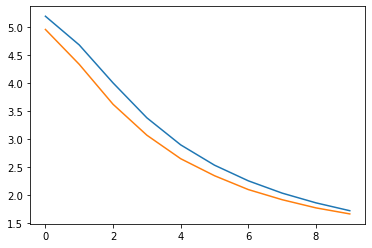

In [30]:
plt.plot (training_loss)
plt.plot (validation_loss)

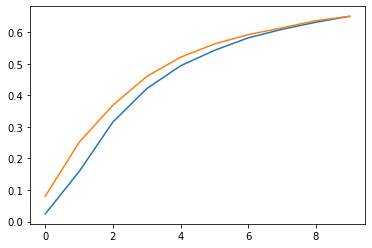

In [31]:
plt.plot(training_accuracy)
plt.plot(validation_accuracy)

In [32]:
criterion = nn.CrossEntropyLoss()

In [33]:
predicted = []
total_correct = 0
total_images = 0
confusion_mat = np.zeros([200,200],int)              #inintializing the confusion matrix
with torch.no_grad():
    for inputs,labels in dataloaders['test1']:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs  = model(inputs)
      loss = criterion(outputs,labels)
      _,predicted = torch.max(outputs,1)

      total_images += labels.size(0)
      total_correct += (predicted == labels).sum().item()
      for i, l in enumerate(labels):
        confusion_mat[l.item(), predicted[i].item()] += 1          # Row = actual class , COl = predicted class                      

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

Model accuracy on 5000 test images: 65.72%


In [34]:
cross_metric = metric(confusion_mat)
print(cross_metric)

(0.6605422368823348, 0.6639186418911577)


loss focal loss


In [10]:
# code for the focal loss as it in not available in pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [11]:
criterion = FocalLoss()

In [15]:
model,training_loss1,training_accuracy1,validation_loss1,validation_accuracy1= train_val_model(model,dataloaders,criterion,optimizer,num_epochs=10)

Epoch 1/10


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


train Loss: 1.6042 Acc: 0.6691
valid1 Loss: 1.5607 Acc: 0.6638
Epoch 2/10
train Loss: 1.5047 Acc: 0.6830
valid1 Loss: 1.4839 Acc: 0.6722
Epoch 3/10
train Loss: 1.4225 Acc: 0.6961
valid1 Loss: 1.4260 Acc: 0.6832
Epoch 4/10
train Loss: 1.3473 Acc: 0.7081
valid1 Loss: 1.3713 Acc: 0.6896
Epoch 5/10
train Loss: 1.2839 Acc: 0.7178
valid1 Loss: 1.3238 Acc: 0.6978
Epoch 6/10
train Loss: 1.2240 Acc: 0.7289
valid1 Loss: 1.2816 Acc: 0.7032
Epoch 7/10
train Loss: 1.1721 Acc: 0.7373
valid1 Loss: 1.2447 Acc: 0.7082
Epoch 8/10
train Loss: 1.1235 Acc: 0.7459
valid1 Loss: 1.2184 Acc: 0.7148
Epoch 9/10
train Loss: 1.0802 Acc: 0.7551
valid1 Loss: 1.1903 Acc: 0.7196
Epoch 10/10
train Loss: 1.0389 Acc: 0.7626
valid1 Loss: 1.1649 Acc: 0.7196


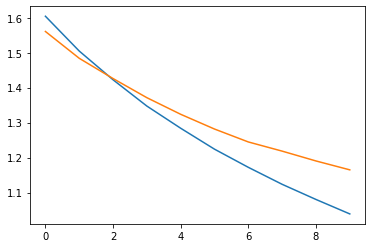

In [16]:
plt.plot (training_loss1)
plt.plot (validation_loss1)

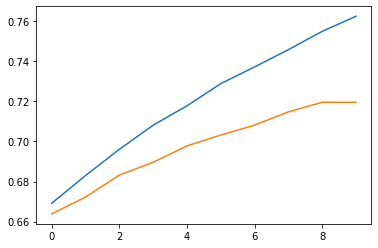

In [17]:
plt.plot(training_accuracy1)
plt.plot(validation_accuracy1)

In [18]:
criterion = FocalLoss()

In [20]:
import numpy as np


In [21]:
predicted = []
total_correct = 0
total_images = 0
confusion_mat = np.zeros([200,200],int)              #inintializing the confusion matrix
with torch.no_grad():
    for inputs,labels in dataloaders['test1']:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs  = model(inputs)
      loss = criterion(outputs,labels)
      _,predicted = torch.max(outputs,1)

      total_images += labels.size(0)
      total_correct += (predicted == labels).sum().item()
      for i, l in enumerate(labels):
        confusion_mat[l.item(), predicted[i].item()] += 1          # Row = actual class , COl = predicted class                      

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Model accuracy on 5000 test images: 72.58%


In [22]:
def metric(y_focal): #this will return F-1 macros score
    size=len(y_focal)
    row_sum  =  y_focal.sum(axis=1)
    col_sum  =  y_focal.sum(axis=0)
    tp_i=[]
    for i in range(size):
      for j in range(size):
        if i ==j :
          tp_i.append(y_focal[i][j])
    tp_i=np.array(tp_i) 
    precision=[]
    recall=[]
    for i in range(size): 
      precision.append(tp_i[i]/col_sum[i])   
      recall.append(tp_i[i]/row_sum[i])   
    pre = np.array(precision)
    rec= np.array(recall)
    macro_precision = pre.sum()/len(pre)
    macro_recall = rec.sum()/len(rec)
    num_f1 = 2 * (macro_precision * macro_recall)
    den_f1 =  (macro_precision + macro_recall)
    macro_f1_score = num_f1 / den_f1
    return macro_f1_score, macro_precision

In [23]:
focal_metric = metric(confusion_mat)
print(focal_metric)

(0.7295993396755168, 0.7334386654141032)
